In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-model-optimization
!pip install xarray-spatial
!pip install rasterio
!pip install tensorflow-io
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59413 sha256=31b2935a489bf8d90f23186e99b28678b5e022e385068ade89c5f01c74a8eef9
  Stored in directory: /root/.cache/pip/wheels/35/c6/63/a3c12ecc9fdea10a593271de5c56481b427ad4049b90a176e1
Successfully built datashape
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.33.0
    Uninstalling tensorflow-io-gcs-filesystem-0.33.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.33.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.3 MB/s eta 0:00:00


# Download Dataset From Kaggle
* include the kaggle key in the collab notebook in drive

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d hmendonca/cloud-cover-detection

100% 16.2G/16.2G [02:30<00:00, 85.1MB/s]
100% 16.2G/16.2G [02:31<00:00, 115MB/s] 


In [ ]:
! unzip  /content/cloud-cover-detection.zip

*Python Imports*

In [ ]:
import keras
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import rasterio as rasterio
import os
import tensorflow as tf
import random
import os
import pickle
import json
import pandas as pd

os.environ['SM_FRAMEWORK'] = 'tf.keras'

seed  = 42
random.seed(seed)


# EDA

## check for any missing Folders and images



*   lets check if all the folders in traindataset have 4 files
*   lets also check if the folders have a matching cloud mask image


In [ ]:
folders_in_train_features  = sorted(os.listdir('/content/data/train_features'))
images_in_train_labels = sorted(os.listdir('/content/data/train_labels'))

missing_features_folders = []
for folder in folders_in_train_features:
  if len(os.listdir(os.path.join('/content/data/train_features',folder))) !=4:
    missing_features_folders.append(folder)
if len(missing_features_folders) <=0:
  print("all folders have 4 images")
else:
  print(f"these folders are missing some images {missing_features_folders}")

missing_labels_folders = []
for folder in folders_in_train_features:
  if f'{folder}.tif' not in images_in_train_labels:
    missing_labels_folders.append(folder)
if len(missing_labels_folders) <=0:
  print("no folders have missing labels")
else:
  print(f"these folders are missing their labels {missing_labels_folders}")

all folders have 4 images
no folders have missing labels


## Visualizing the images and image bands



*   visualizing the 4 image bands
*   3 of the bands are the red blue-and green channel 4th is infrared
*   combinning the red,blue,green channel gives us color image
*   applying sigmoid normaizaing gives a image with good contrast
*   visualizing the image mask as as the masked red channel





In [ ]:
from posix import read
import xrspatial.multispectral as ms
import xarray
from skimage.metrics import mean_squared_error

def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(folder_path):
    red = get_xarray(os.path.join(folder_path,"B04.tif"))
    green = get_xarray(os.path.join(folder_path,"B03.tif"))
    blue = get_xarray(os.path.join(folder_path,"B02.tif"))

    return ms.true_color(r=red, g=green, b=blue)

def read_tif_image(path):
  with rasterio.open(path) as img_file:
    img = img_file.read(1).astype(int)
  return img

def normalize(image):
  min_value = np.min(image)
  max_value = np.max(image)
  # Normalize the combined image to the [0, 1] range
  normalized_image = (image - min_value) / (max_value - min_value)
  return normalized_image

def normalize_with_sigmoid(image, c=10, th=0.125):
    # Apply sigmoid-based contrast enhancement
    normalized_image = 1 / (1 + np.exp(c * (th - image)))

    return normalized_image

import cv2
def display_four_image(image_folder_path):
  images = []
  for band in [2,3,4,8]:
    pth = os.path.join(image_folder_path,f'B0{band}.tif')
    img = read_tif_image(pth)
    images.append(img)

  combined_image = np.stack((images[2],images[1],images[0]),axis=-1)

  truecolor  = true_color_img(image_folder_path)

  mask = read_tif_image(f"{os.path.join('/content/data/train_labels',image_folder_path.split('/')[-1])}.tif")

  # Create a figure with 2x2 subplots
  fig, axs = plt.subplots(4, 2,figsize=(10, 10))

  # Display the images on the subplots
  axs[0, 0].imshow(images[0], cmap='pink')
  axs[0, 0].set_title('Blue visible light')

  axs[0, 1].imshow(images[1], cmap='pink')
  axs[0, 1].set_title('Green visible light')

  axs[1, 0].imshow(images[2], cmap='pink')
  axs[1, 0].set_title('Red visible light')

  axs[1, 1].imshow(images[3], cmap='pink')
  axs[1, 1].set_title('Near infrared light')

  axs[2, 0].imshow(normalize(combined_image))
  axs[2, 0].set_title('Color')
  axs[2, 1].imshow(truecolor)
  axs[2, 1].set_title('TrueColor')


  axs[3, 0].set_title('masked image')
  axs[3, 0].imshow(images[3]*mask, cmap='pink')
  axs[3, 1].set_title('mask')
  axs[3, 1].imshow(mask)
  print(f"unique values in mask {np.unique(mask)}")

  # Adjust spacing between subplots
  plt.tight_layout()

  # Show the figure
  plt.show()

  return(combined_image)

unique values in mask [0 1]


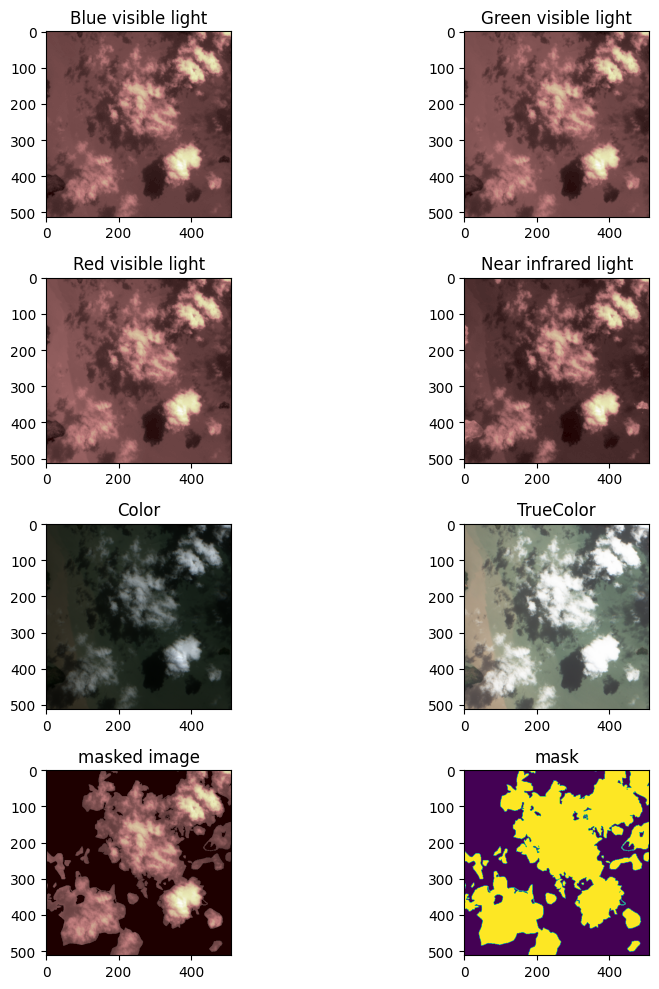

In [ ]:
c = display_four_image('/content/data/train_features/adwp')

## Correlation between channels



*   identifying the correlation between a channel and the image mask
*   checking correlation with one example for each od the 4 bands



[0 1]


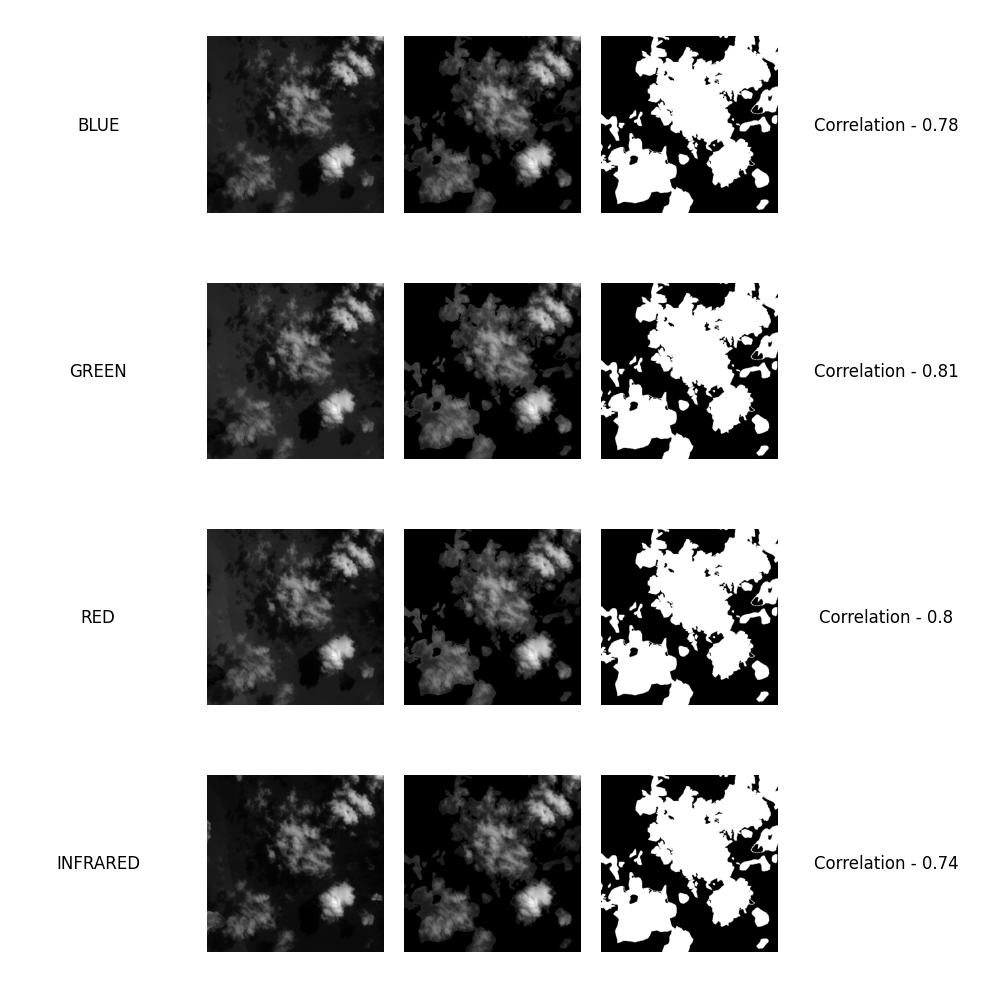

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load your spectral band images (replace these with actual file paths)
band_paths = ['/content/data/train_features/adwp/B02.tif','/content/data/train_features/adwp/B03.tif',
              '/content/data/train_features/adwp/B04.tif','/content/data/train_features/adwp/B08.tif']
band_names = ['BLUE','GREEN','RED','INFRARED']
bands = [read_tif_image(path) for path in band_paths]

target = read_tif_image('/content/data/train_labels/adwp.tif')
print(np.unique(target))

def calculate_band_correlation(band, mask):
    # Flatten the band and mask arrays
    band_flat = band.flatten()
    mask_flat = mask.flatten()

    # Calculate the correlation between the flattened band and the flattened mask
    corr, _ = pearsonr(band_flat, mask_flat)  # Exclude cloudy pixels (mask = 1)
    return abs(corr)


# Calculate and visualize correlations between all pairs of bands
num_bands = len(bands)
fig, axes = plt.subplots(num_bands, 5, figsize=(10, 10))

for i in range(num_bands):
  image = bands[i]
  og_image = bands[i]
  image = image*target
  image = normalize(image)
  corr = round(calculate_band_correlation(image,target),2)

  axes[i, 0].text(0.5, 0.5, f'{band_names[i]}', fontsize=12, ha='center', va='center')
  axes[i, 1].imshow(og_image, cmap='gray')
  axes[i, 2].imshow(image, cmap='gray')
  axes[i, 3].imshow(target, cmap='gray')
  axes[i, 4].text(0.5, 0.5, f'Correlation - {corr}', fontsize=12, ha='center', va='center')
  for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()


## find the 3 bands that are most correlated to the cloud mask



*   if we were to select any 3 channels we would need to see which 3bands are sutiable



In [ ]:
from tqdm import tqdm
percentage_to_consider = 10      #taking entire data will take long time to process on slower machines
all_folders = sorted(os.listdir('/content/data/train_features'))
num_folders_to_consider = int(len(all_folders) * (percentage_to_consider / 100))
folders_to_process = random.sample(all_folders, num_folders_to_consider)

all_correaltions = []
for folder in tqdm(folders_to_process):
  mask = read_tif_image(os.path.join('/content/data/train_labels',f'{folder}.tif'))
  band1= read_tif_image(os.path.join('/content/data/train_features',folder,'B02.tif'))
  band2= read_tif_image(os.path.join('/content/data/train_features',folder,'B03.tif'))
  band3= read_tif_image(os.path.join('/content/data/train_features',folder,'B04.tif'))
  band4= read_tif_image(os.path.join('/content/data/train_features',folder,'B08.tif'))

  correaltions = []
  for band in [band1,band2,band3,band4]:
    image = band
    target = mask
    image = normalize(image)
    image = image*target
    corr = round(calculate_band_correlation(image,target),2)
    correaltions.append(corr)

  all_correaltions.append(correaltions)

  1%|          | 12/1174 [00:01<02:13,  8.69it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 1174/1174 [01:46<00:00, 11.04it/s]


In [ ]:
column_names = ['Band1', 'Band2', 'Band3', 'Band4']
# Create a Pandas DataFrame from the list of correlations
df = pd.DataFrame(all_correaltions, columns=column_names)
df['Top3Bands'] = df.apply(lambda row: ', '.join(row.nlargest(3).index), axis=1)
df['Top3Bands'] = df['Top3Bands'].str.split(', ').apply(sorted)

df.head(4)



,Band1,Band2,Band3,Band4,Top3Bands
0,0.58,0.58,0.58,0.67,"[Band1, Band2, Band4]"
1,0.64,0.62,0.62,0.71,"[Band1, Band2, Band4]"
2,0.70,0.73,0.73,0.87,"[Band2, Band3, Band4]"
3,0.56,0.56,0.55,0.64,"[Band1, Band2, Band4]"



*   Looks like bands 1,2,3 have highest correlation to the image mask
*   this also works in our favour as the bands 1,2,3 are the Red Blue and Green channels



In [ ]:
band_counts = df['Top3Bands'].value_counts()
band_counts

[Band1, Band2, Band3]    485
[Band2, Band3, Band4]    439
[Band1, Band2, Band4]    216
[Band1, Band3, Band4]     34
Name: Top3Bands, dtype: int64

# Fine Tune Segformer





*   fine tuning a segformer model which is a visual-transformer model for semantic segmentation

* using a custom tensorflow implentation of segformer with layers that
I modified for  model optimization and pruning

*   SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers [Paper Link](https://arxiv.org/abs/2105.15203)






.

clone the model architecture from githb repo as notebook become too big if included here

In [ ]:
! rm -rf '/content/SegFormer-tf'
! rm -rf '/content/SegFormertf'
! git clone "https://github.com/tejas1904/SegFormer-tf.git"
! mv '/content/SegFormer-tf' '/content/SegFormertf'

Cloning into 'SegFormer-tf'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 169 (delta 19), reused 17 (delta 12), pack-reused 133
Receiving objects: 100% (169/169), 6.20 MiB | 12.63 MiB/s, done.
Resolving deltas: 100% (72/72), done.


## create tensorflow dataset for segformer with  Image augmentations

image augmentations

*   Random Brightness
*   Random Contrast
*   Random horizantal and verical Flip

Mask augmentaation

* Random horizantal and verical Flip







In [ ]:
class Augment_segformer(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()

    self.augment_inputs = tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0,1), seed=seed)
    self.augment_inputs = tf.keras.layers.RandomContrast(factor=0.2, seed=seed)
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)

    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)

  def call(self, inputs , labels):


    inputs = self.augment_inputs(inputs)

    labels = tf.expand_dims(labels, axis=-1)
    labels = self.augment_labels(labels)
    labels = tf.squeeze(labels, axis=-1)

    return inputs,labels

Data Loader

*   combines red,blue and green channel
*   resizes image and mask applies augmetations and returns data






In [ ]:
import tensorflow_io as tfio
image_resize_shape = (224,224)
def load_image_for_segformer(folder, images_folder='/content/data/train_features', mask_folder='/content/data/train_labels'):
    images = []
    for band in [4, 3, 2]:
        pth = tf.strings.join([images_folder,folder,f'B0{band}.tif'],separator='/')
        img = tf.io.read_file(pth)
        img = tfio.experimental.image.decode_tiff(img, index=0, name=None)
        img= img[:,:,0]
        # pth = os.path.join(images_folder,folder.numpy().decode('utf-8'),f'B0{band}.tif')
        # img = read_tif_image(pth)
        images.append(img)

    # Stack the images and normalize the combined image
    combined_image = tf.stack(images, axis=-1)

    #resize
    combined_image_resized = tf.image.resize(combined_image, image_resize_shape)

    # Normalize the combined image to the [0, 1] range
    min_value = tf.reduce_min(combined_image_resized)
    max_value = tf.reduce_max(combined_image_resized)
    normalized_image = (combined_image_resized - min_value) / (max_value - min_value)

    #normalized_transposed_image  =  tf.transpose(normalized_image, (2, 0, 1))


    ##### reading the mask image ################

    pth_mask = tf.strings.join([mask_folder,'/',folder,'.tif'])
    img_mask = tf.io.read_file(pth_mask)
    img_mask = tfio.experimental.image.decode_tiff(img_mask, index=0, name=None)
    img_mask = tf.image.resize(img_mask, image_resize_shape,method='nearest')
    img_mask = img_mask[:,:,0]


    return tf.cast(normalized_image,tf.float32) , tf.squeeze(tf.cast(img_mask,tf.float32 ))

In [ ]:
folders_images = sorted(os.listdir('/content/data/train_features'))
folders_images = tf.constant(folders_images, dtype=tf.string)
dataset_images = tf.data.Dataset.from_tensor_slices(folders_images).map(load_image_for_segformer).map(Augment_segformer())

Visualize a dataset element

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224), dtype=tf.float32, name=None))


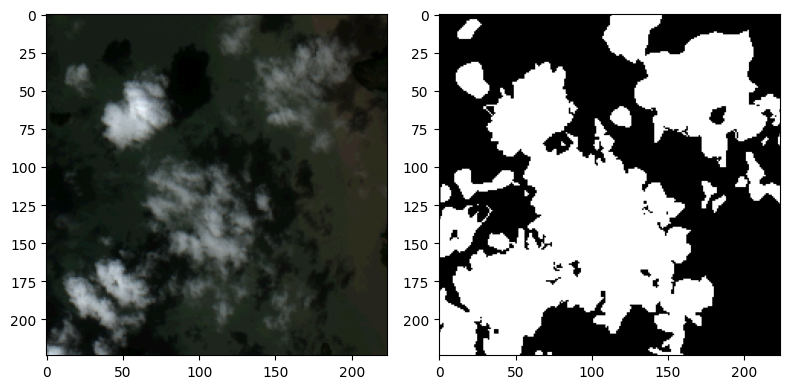

In [ ]:
for i in dataset_images:
  print(dataset_images.element_spec)
  image , labels = i
  fig, axs = plt.subplots(1, 2,figsize=(8,8))
  axs[0].imshow(image)
  axs[1].imshow(labels,cmap='gray')
  plt.tight_layout()
  plt.show()
  break

## create and train segformer model



*   Training a segformer B0 model with input 224x224



In [ ]:
from SegFormertf.models import SegFormer_B0

segformer_model = SegFormer_B0(input_shape=(224, 224, 3), num_classes=2)


segformer_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

create the datasets for train , test and val

In [ ]:
try:
  with open('/content/drive/MyDrive/cloudcover/folders.json', 'r') as file:
    folders = json.load(file)
  print("loaded existing folder list")
except:
  folders = os.listdir('/content/data/train_features')
  random.seed(seed)
  random.shuffle(folders)  # Shuffle the list
  print("loaded new folder list")
print(folders)

# Define the proportions for your splits (e.g., 60% training, 20% validation, 20% testing)
train_split , test_split ,val_split , = 0.7 , 0.2 , 0.1
total_length = len(folders)
train_length = int(train_split * total_length)
test_length = int(test_split * total_length)

# Split the list into training, validation, and testing sets using slicing
train_set = folders[:train_length]
test_set = folders[train_length : train_length + test_length]
val_set = folders[train_length + test_length:]

# Create a TensorFlow constant from the list of folders
folders_train = tf.constant(train_set, dtype=tf.string)
folders_test = tf.constant(test_set, dtype=tf.string)
folders_val = tf.constant(val_set, dtype=tf.string)

# Create a dataset by mapping the load_image function over the folder names
train_dataset = tf.data.Dataset.from_tensor_slices(folders_train).map(load_image_for_segformer , num_parallel_calls=tf.data.AUTOTUNE).map(Augment_segformer(), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(folders_test).map(load_image_for_segformer , num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(folders_val).map(load_image_for_segformer , num_parallel_calls=tf.data.AUTOTUNE)

loaded existing folder list
['pgxo', 'juvs', 'hqmx', 'obdp', 'ezzm', 'ylib', 'cndj', 'qkrz', 'ixuw', 'siqv', 'swjm', 'zwjg', 'rqwp', 'wvhe', 'izxf', 'weeb', 'ohka', 'vsmk', 'gidz', 'tkic', 'dkos', 'yncm', 'mumc', 'zwss', 'lxur', 'dflp', 'mfzg', 'nkqk', 'dtpu', 'hnmu', 'ocxx', 'vzuy', 'vwbp', 'xpvz', 'zwht', 'spxe', 'wdvy', 'euyx', 'rama', 'evxt', 'cqrx', 'auoi', 'wuci', 'yxcy', 'svdc', 'iiir', 'lbri', 'pjxa', 'rcbv', 'vdgg', 'jvfh', 'hwez', 'sgpc', 'lyef', 'giwk', 'svhl', 'dkfs', 'nbws', 'pgdh', 'tbwa', 'oahd', 'xgvl', 'nlyd', 'yxuc', 'wyll', 'lvqt', 'clre', 'zxwv', 'xtme', 'ekbl', 'nzxh', 'gqpl', 'yahl', 'mpoh', 'ywih', 'aftu', 'msbc', 'tatu', 'rbfy', 'javc', 'dxvq', 'tfxy', 'caom', 'elen', 'apmg', 'odnj', 'muau', 'crlj', 'hxxp', 'ocrc', 'zwhu', 'zadf', 'aqbd', 'vthi', 'nmzf', 'phzz', 'elih', 'mxbl', 'zvgs', 'pjpc', 'ylej', 'xkoh', 'qrpl', 'xvco', 'cnmy', 'mwsy', 'slhn', 'ezwq', 'xziy', 'xbul', 'mvqh', 'ocxf', 'xlvr', 'ejpy', 'wduy', 'cpyv', 'rpxs', 'ggtr', 'qqll', 'qysg', 'cpju', 'ih

load the model from a checkpiont if available or create a new one

In [ ]:
epochs = 15

callbacks1 = [
    keras.callbacks.ModelCheckpoint("/content/SaveModel/save_at_{epoch}.keras"),
]

callbacks2 = tf.keras.callbacks.BackupAndRestore(
    backup_dir="/content/drive/MyDrive/cloudcover/tfvision",
    delete_checkpoint=False,
    )

history = segformer_model.fit(
    train_dataset.shuffle(100).batch(32).prefetch(tf.data.AUTOTUNE),
    validation_data=val_dataset.shuffle(100).batch(16).prefetch(tf.data.AUTOTUNE),
    callbacks=[callbacks2],
    epochs=epochs,
)

Plotting the training and validation loss for 15 epochs

loaded saved history of the model


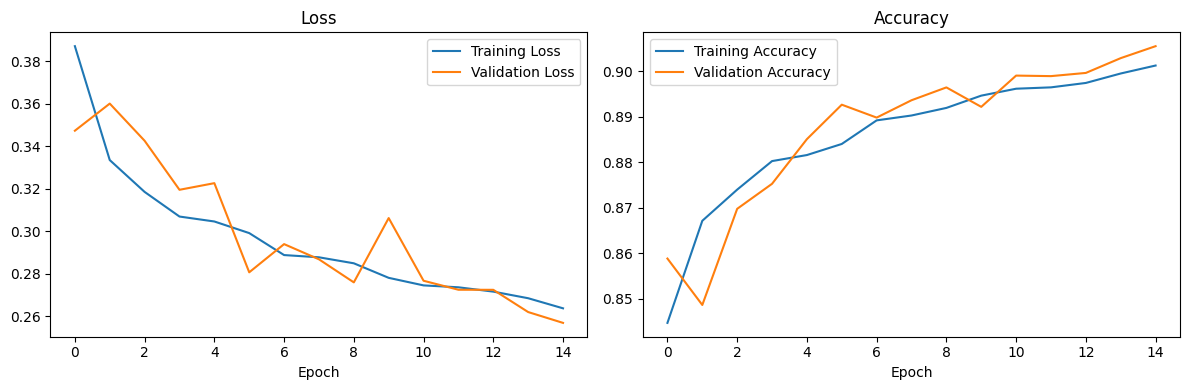

In [ ]:
import pickle
# with open('/content/drive/MyDrive/cloudcover/hist', 'wb') as file_pi:
#     pickle.dump(history, file_pi)
# Assuming you have a 'history' object

if not bool(history.history): #if history is empty load a previous saved
  with open('/content/drive/MyDrive/cloudcover/hist', "rb") as file_pi:
      history = pickle.load(file_pi)
  print('loaded saved history of the model')
else:
  history = history.history


train_loss = history['loss']
train_accuracy = history['accuracy']
val_loss = history['val_loss']  # If you have validation data
val_accuracy = history['val_accuracy']  # If you have validation data
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
if 'val_loss' in history:
    plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
if 'val_accuracy' in history:
    plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# segformer_model.save('/content/drive/MyDrive/cloudcover/segformer.keras')

## visualize segformer predection

1/1 [==============================] - 10s 10s/step
(224, 224, 2)
(224, 224)
[0 1]


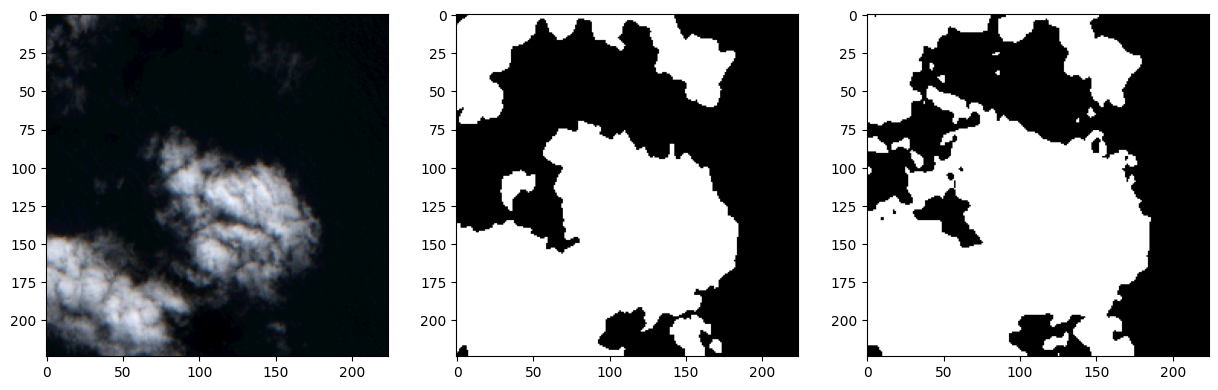

In [ ]:
i = test_dataset.take(1)
i = list(i)[0]
image,map = i
predection = segformer_model.predict(np.expand_dims(image,0))[0]
print(np.shape(predection))
predection = tf.math.argmax(predection, axis=-1)
print(np.shape(predection))
print(np.unique(predection))
fig, axs = plt.subplots(1, 3,figsize=(15,15))
axs[0].imshow(image)
axs[1].imshow(map,cmap='gray')
axs[2].imshow(predection,cmap='gray')
plt.show()

#Model performance metrics

## IOU,PRECISION,RECALL,F1

* on the test dataset

In [ ]:
tf.data.experimental.cardinality(test_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=2349>

In [ ]:
def load_only_image_for_segformer(folder, images_folder='/content/data/train_features', mask_folder='/content/data/train_labels'):
    images = []
    for band in [4, 3, 2]:
        pth = tf.strings.join([images_folder,folder,f'B0{band}.tif'],separator='/')
        img = tf.io.read_file(pth)
        img = tfio.experimental.image.decode_tiff(img, index=0, name=None)
        img= img[:,:,0]
        # pth = os.path.join(images_folder,folder.numpy().decode('utf-8'),f'B0{band}.tif')
        # img = read_tif_image(pth)
        images.append(img)

    # Stack the images and normalize the combined image
    combined_image = tf.stack(images, axis=-1)

    #resize
    combined_image_resized = tf.image.resize(combined_image, image_resize_shape)

    # Normalize the combined image to the [0, 1] range
    min_value = tf.reduce_min(combined_image_resized)
    max_value = tf.reduce_max(combined_image_resized)
    normalized_image = (combined_image_resized - min_value) / (max_value - min_value)

    return [[tf.cast(normalized_image,tf.float32)]]

In [ ]:
test_dataset_imgs = tf.data.Dataset.from_tensor_slices(folders_test[:]).map(load_only_image_for_segformer , num_parallel_calls=tf.data.AUTOTUNE)
predections = segformer_model.predict(test_dataset_imgs)

2349/2349 [==============================] - 67s 28ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix

# Initialize lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []  # Change the list name to f1_scores
iou_scores = []

i = 0

for data in test_dataset.take(tf.data.experimental.cardinality(test_dataset)):
    image, map = data
    predection = predections[i]
    i += 1

    # Convert prediction to binary mask
    predection = tf.math.argmax(predection, axis=-1)
    predection = tf.image.resize(tf.expand_dims(predection, -1), map.shape)
    predection = tf.squeeze(predection)
    predection = tf.where(predection > 0.5, 1.0, 0.0)

    # Flatten the ground truth and prediction masks
    map_flat = tf.reshape(map, [-1])
    predection_flat = tf.reshape(predection, [-1])

    # Calculate metrics
    accuracy = accuracy_score(map_flat, predection_flat,)
    precision = precision_score(map_flat, predection_flat, zero_division=1)
    recall = recall_score(map_flat, predection_flat, zero_division=1)
    f1 = f1_score(map_flat, predection_flat, zero_division=1)  # Use f1_score
    iou = jaccard_score(map_flat, predection_flat, average="micro", zero_division=1)

    # Append metrics to respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)  # Append the F1 score
    iou_scores.append(iou)

    # # Calculate and print confusion matrix
    # cm = confusion_matrix(map_flat, predection_flat)
    print(f"\r Iteration {i}:", end=' ')



# Calculate and print overall metrics
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)
average_iou = sum(iou_scores) / len(iou_scores)

print("\n Overall Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F2 Score: {average_f1}")
print(f"Average IOU: {average_iou}")



 Iteration 2349: 
 Overall Metrics:
Average Accuracy: 0.9018111165682756
Average Precision: 0.8837928979444711
Average Recall: 0.8830627579920519
Average F2 Score: 0.8398050111734149
Average IOU: 0.8530160700916439


# Model optimization



*   lets explore model optimization by pruning and quantization
*   pruning makes the model weights sparse leading to smaller size and faster inference

* qunatization reduces model inference time by quantizing the weights to lower-precision which works well for low power devices





## Model Pruning

*   before pruning the model



In [ ]:
segformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mix_vision_transformer (Mi  [(None, 56, 56, 32),         3319392   ['input_1[0][0]']             
 xVisionTransformer)          (None, 28, 28, 64),                                                 
                              (None, 14, 14, 160),                                                
                              (None, 7, 7, 256)]                                                  
                                                                                                  
 seg_former_head (SegFormer  (None, 56, 56, 2)            395778    ['mix_vision_transformer[0



*   the size of the model before pruning is 13.5 mb




In [ ]:
import tempfile
def get_gzipped_model_size(model):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, keras_file = tempfile.mkstemp('aa.keras')
  model.save(keras_file)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)

  return os.path.getsize(zipped_file)

print("Size of gzipped original model without stripping: %.2f mb" % (get_gzipped_model_size(segformer_model)/(1024*1000)))

Size of gzipped original model without stripping: 13.42 mb


* The accuracy of the model before pruning (note it)




In [ ]:
#before pruning
segformer_model.evaluate(val_dataset.batch(32))

37/37 [==============================] - 37s 728ms/step - loss: 0.2568 - accuracy: 0.9055


[0.2567562460899353, 0.9054597020149231]

In [ ]:
#save the weights
segformer_model.save_weights('beforePrune/before_prune')

* create a new prunable model
* copy the weights of the old trained model to new one
* set some target sparsity (here i have set to 80% sparse)
* finetune new pruned model

In [ ]:
#apply pruning to mix_transoformer layer
import tensorflow_model_optimization as tfmot
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
    target_sparsity=0.8, begin_step=0, end_step=-1, frequency=10
)
}

def apply_pruning_to_specific(layer):
  if 'mix_vision_transformer' in layer.name:
    return tfmot.sparsity.keras.prune_low_magnitude(layer,**pruning_params)
  else:
     return layer



model_for_pruning = keras.models.clone_model(segformer_model,
                                                clone_function=apply_pruning_to_specific)
#load back the saved weights
model_for_pruning.load_weights('beforePrune/before_prune')

model_for_pruning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 prune_low_magnitude_mix_vi  [(None, 56, 56, 32),         5380317   ['input_1[0][0]']             
 sion_transformer (PruneLow   (None, 28, 28, 64),                                                 
 Magnitude)                   (None, 14, 14, 160),                                                
                              (None, 7, 7, 256)]                                                  
                                                                                                  
 seg_former_head (SegFormer  (None, 56, 56, 2)            395778    ['prune_low_magnitude_mix_

In [ ]:
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
]

model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_for_pruning.fit(
    val_dataset.shuffle(100).batch(16).prefetch(tf.data.AUTOTUNE),
    callbacks=callbacks,
    epochs=1,
)

74/74 [==============================] - 94s 406ms/step - loss: 0.3558 - accuracy: 0.8652


Ater pruning the model we have to export it by stripping the connections

In [ ]:
#exporting
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()
model_for_export.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mix_vision_transformer (Mi  [(None, 56, 56, 32),         3319392   ['input_1[0][0]']             
 xVisionTransformer)          (None, 28, 28, 64),                                                 
                              (None, 14, 14, 160),                                                
                              (None, 7, 7, 256)]                                                  
                                                                                                  
 seg_former_head (SegFormer  (None, 56, 56, 2)            395778    ['mix_vision_transformer[1

* pruned model after finetuning has lost some accuracy but nothing significant

In [ ]:
#after pruning
model_for_export.evaluate(val_dataset.batch(32))

37/37 [==============================] - 26s 486ms/step - loss: 0.3317 - accuracy: 0.8857


[0.331725150346756, 0.8857249617576599]

* size of the pruned and stripped model is now just 8.5 mb from 13.5 mb

In [ ]:
print("Size of gzipped pruned model without stripping: %.2f mb" % (get_gzipped_model_size(model_for_pruning)/(1024*1000)))
print("Size of gzipped pruned model with stripping: %.2f mb" % (get_gzipped_model_size(model_for_export)/(1024*1000)))

Size of gzipped pruned model without stripping: 38.27 mb
Size of gzipped pruned model with stripping: 8.35 mb


## quantization

* perform dynamic quantization to reduce themodel size an inference speed
* float or int quantization can also be used but could lead to low accuracy
* the pruned model on quantization is now only 4mb after quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

# _, quantized_and_pruned_tflite_file = tempfile.mkstemp('at.tflite')
quantized_and_pruned_tflite_file = 'tflitemodel.tflite'

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

# print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)
# print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_model)))

In [ ]:
print(f"size of the tf lite quantized model in Mb {os.path.getsize('/content/tflitemodel.tflite')/(1024*1000)}")

size of the tf lite quantized model in Mb 4.0210390625


# Finetune a UNET model




*   Fine Tuning a unet model to compare its performance with segformer on the same dataset
*   same input feature size of 224x224 used and augmentations
* unet has a pretrained mobilenet architecture as backbone
Results
* IOU is comparatively lesser than Segformer



## create tensorflow dataset for unet

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()

    self.augment_inputs = tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0,1), seed=seed)
    self.augment_inputs = tf.keras.layers.RandomContrast(factor=0.2, seed=seed)
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)

    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)

    labels = tf.expand_dims(labels, axis=-1)
    labels = self.augment_labels(labels)
    labels = tf.squeeze(labels, axis=-1)
    return inputs,labels

In [ ]:
import tensorflow_io as tfio
image_resize_shape = (224,224)
def load_image(folder, images_folder='/content/data/train_features', mask_folder='/content/data/train_labels'):
    images = []
    for band in [4, 3, 2]:
        pth = tf.strings.join([images_folder,folder,f'B0{band}.tif'],separator='/')
        img = tf.io.read_file(pth)
        img = tfio.experimental.image.decode_tiff(img, index=0, name=None)
        img= img[:,:,0]
        # pth = os.path.join(images_folder,folder.numpy().decode('utf-8'),f'B0{band}.tif')
        # img = read_tif_image(pth)
        images.append(img)

    # Stack the images and normalize the combined image
    combined_image = tf.stack(images, axis=-1)

    #resize
    combined_image_resized = tf.image.resize(combined_image, image_resize_shape)

    # Normalize the combined image to the [0, 1] range
    min_value = tf.reduce_min(combined_image_resized)
    max_value = tf.reduce_max(combined_image_resized)
    normalized_image = (combined_image_resized - min_value) / (max_value - min_value)


    #####reading the mask image################

    pth_mask = tf.strings.join([mask_folder,'/',folder,'.tif'])
    img_mask = tf.io.read_file(pth_mask)
    img_mask = tfio.experimental.image.decode_tiff(img_mask, index=0, name=None)
    img_mask = tf.image.resize(img_mask, image_resize_shape,method='nearest')
    img_mask = img_mask[:,:,0]

    percent_cloud_cover = (tf.cast(tf.reduce_sum(img_mask),tf.int32)/ tf.size(img_mask)) * 100
    percent_cloud_cover = tf.reduce_sum(img_mask)

    return [tf.cast(normalized_image,tf.float32),tf.cast(img_mask,tf.float32 )]

# List of folders to process
folders_images = sorted(os.listdir('/content/data/train_features'))

# Create a TensorFlow constant from the list of folders
folders_images = tf.constant(folders_images, dtype=tf.string)

# Create a dataset by mapping the load_image function over the folder names
dataset_images = tf.data.Dataset.from_tensor_slices(folders_images).map(load_image).map(Augment())

tf.Tensor([224 224   3], shape=(3,), dtype=int32)
tf.Tensor([224 224], shape=(2,), dtype=int32)


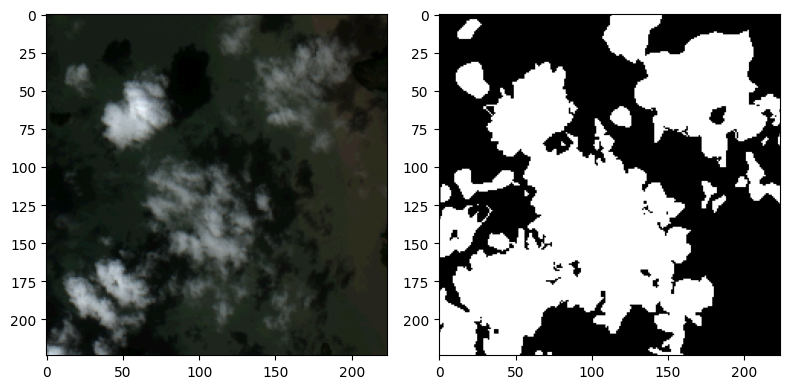

In [ ]:
for i in dataset_images:
  print(tf.shape(i[0]))
  print(tf.shape(i[1]))
  # print(tf.shape(i[2]))
  # print(i[2])
  fig, axs = plt.subplots(1, 2,figsize=(8,8))
  axs[0].imshow(i[0])
  axs[1].imshow(i[1],cmap='gray')
  plt.tight_layout()
  plt.show()
  break

## create and train unet model

In [ ]:
import segmentation_models as sm
model = sm.FPN('mobilenetv2', classes=1, activation='sigmoid', encoder_weights='imagenet',
               input_shape=(image_resize_shape[0],image_resize_shape[1],3)
               )
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

Segmentation Models: using `tf.keras` framework.


In [ ]:
# List of folders to process
try:
  with open('/content/drive/MyDrive/cloudcover/folders.json', 'r') as file:
    folders = json.load(file)
  print("loaded existing folder list")
except:
  folders = os.listdir('/content/data/train_features')
  random.seed(seed)
  random.shuffle(folders)  # Shuffle the list
  print("loaded new folder list")
print(folders)

# Define the proportions for your splits (e.g., 60% training, 20% validation, 20% testing)
train_split , test_split ,val_split , = 0.7 , 0.2 , 0.1
total_length = len(folders)
train_length = int(train_split * total_length)
test_length = int(test_split * total_length)

# Split the list into training, validation, and testing sets using slicing
train_set = folders[:train_length]
test_set = folders[train_length : train_length + test_length]
val_set = folders[train_length + test_length:]

# Create a TensorFlow constant from the list of folders
folders_train = tf.constant(train_set, dtype=tf.string)
folders_test = tf.constant(test_set, dtype=tf.string)
folders_val = tf.constant(val_set, dtype=tf.string)

# Create a dataset by mapping the load_image function over the folder names
train_dataset = tf.data.Dataset.from_tensor_slices(folders_train).map(load_image , num_parallel_calls=tf.data.AUTOTUNE).map(Augment() , num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(folders_test).map(load_image , num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(folders_val).map(load_image , num_parallel_calls=tf.data.AUTOTUNE)


loaded existing folder list
['pgxo', 'juvs', 'hqmx', 'obdp', 'ezzm', 'ylib', 'cndj', 'qkrz', 'ixuw', 'siqv', 'swjm', 'zwjg', 'rqwp', 'wvhe', 'izxf', 'weeb', 'ohka', 'vsmk', 'gidz', 'tkic', 'dkos', 'yncm', 'mumc', 'zwss', 'lxur', 'dflp', 'mfzg', 'nkqk', 'dtpu', 'hnmu', 'ocxx', 'vzuy', 'vwbp', 'xpvz', 'zwht', 'spxe', 'wdvy', 'euyx', 'rama', 'evxt', 'cqrx', 'auoi', 'wuci', 'yxcy', 'svdc', 'iiir', 'lbri', 'pjxa', 'rcbv', 'vdgg', 'jvfh', 'hwez', 'sgpc', 'lyef', 'giwk', 'svhl', 'dkfs', 'nbws', 'pgdh', 'tbwa', 'oahd', 'xgvl', 'nlyd', 'yxuc', 'wyll', 'lvqt', 'clre', 'zxwv', 'xtme', 'ekbl', 'nzxh', 'gqpl', 'yahl', 'mpoh', 'ywih', 'aftu', 'msbc', 'tatu', 'rbfy', 'javc', 'dxvq', 'tfxy', 'caom', 'elen', 'apmg', 'odnj', 'muau', 'crlj', 'hxxp', 'ocrc', 'zwhu', 'zadf', 'aqbd', 'vthi', 'nmzf', 'phzz', 'elih', 'mxbl', 'zvgs', 'pjpc', 'ylej', 'xkoh', 'qrpl', 'xvco', 'cnmy', 'mwsy', 'slhn', 'ezwq', 'xziy', 'xbul', 'mvqh', 'ocxf', 'xlvr', 'ejpy', 'wduy', 'cpyv', 'rpxs', 'ggtr', 'qqll', 'qysg', 'cpju', 'ih

In [ ]:
callbacks2 = tf.keras.callbacks.BackupAndRestore(
    backup_dir="/content/drive/MyDrive/cloudcover/Unet",
    delete_checkpoint=False,
    )
model.fit(
   x = train_dataset.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE),
   epochs=12,
   validation_data = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE),
   callbacks=[callbacks2]
)

In [ ]:
# model.evaluate(test_dataset.batch(32))

## visualize UNET predection

1/1 [==============================] - 4s 4s/step


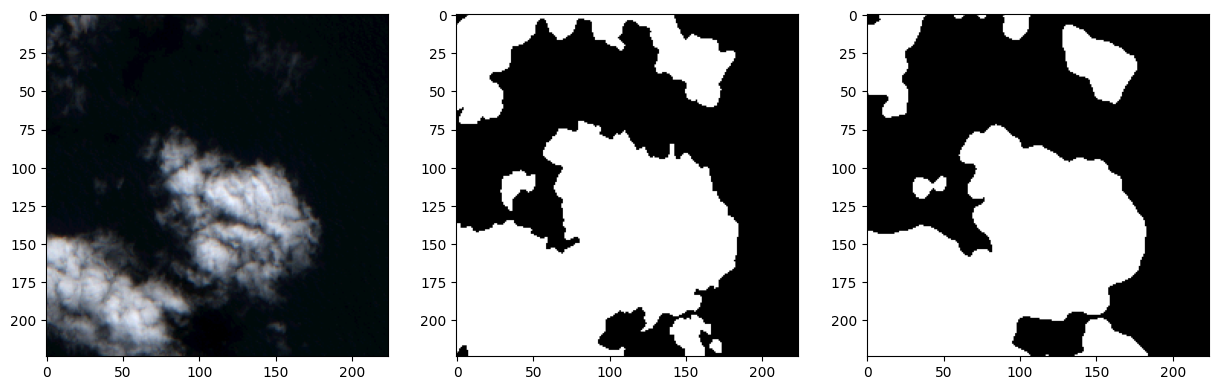

In [ ]:
i = test_dataset.take(1)
i = list(i)[0]
image = i[0]
map = i[1]
predection = model.predict(np.expand_dims(image,0))[0]
predection = np.where(predection > 0.5, 1.0, 0.0)
fig, axs = plt.subplots(1, 3,figsize=(15,15))
axs[0].imshow(image)
axs[1].imshow(map,cmap='gray')
axs[2].imshow(predection,cmap='gray')
plt.show()

In [ ]:
test_dataset_imgs_unet = tf.data.Dataset.from_tensor_slices(folders_test[:]).map(load_only_image_for_segformer , num_parallel_calls=tf.data.AUTOTUNE)
predections_unet = model.predict(test_dataset_imgs_unet)

2349/2349 [==============================] - 54s 22ms/step


In [ ]:
predections_unet.shape

(2349, 224, 224, 1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix

# Initialize lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []  # Change the list name to f1_scores
iou_scores = []

i = 0

for data in test_dataset.take(tf.data.experimental.cardinality(test_dataset)):
    image, map = data
    predection = predections_unet[i]
    i += 1

    # Convert prediction to binary mask
    predection = tf.image.resize(predection, map.shape)
    predection = tf.squeeze(predection)
    predection = tf.where(predection > 0.5, 1.0, 0.0)

    # fig, axs = plt.subplots(1, 3,figsize=(15,15))
    # axs[0].imshow(image)
    # axs[1].imshow(map,cmap='gray')
    # axs[2].imshow(predection,cmap='gray')
    # plt.show()
    # break

    # Flatten the ground truth and prediction masks
    map_flat = tf.reshape(map, [-1])
    predection_flat = tf.reshape(predection, [-1])

    # Calculate metrics
    accuracy = accuracy_score(map_flat, predection_flat,)
    precision = precision_score(map_flat, predection_flat, zero_division=1)
    recall = recall_score(map_flat, predection_flat, zero_division=1)
    f1 = f1_score(map_flat, predection_flat, zero_division=1)  # Use f1_score
    iou = jaccard_score(map_flat, predection_flat, average="micro", zero_division=1)

    # Append metrics to respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)  # Append the F1 score
    iou_scores.append(iou)

    # # Calculate and print confusion matrix
    # cm = confusion_matrix(map_flat, predection_flat)
    print(f"\r Iteration {i}:", end=' ')



# Calculate and print overall metrics
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)
average_iou = sum(iou_scores) / len(iou_scores)

print("Overall Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F2 Score: {average_f1}")
print(f"Average IOU: {average_iou}")



 Iteration 2349: Overall Metrics:
Average Accuracy: 0.8860793149874894
Average Precision: 0.8667571410387604
Average Recall: 0.8668888637289986
Average F2 Score: 0.8230191007484922
Average IOU: 0.82274630620343
